# Training YOLOv8 on Fruits-360 Dataset

This notebook demonstrates how to train a YOLOv8 model for fruit classification using the Fruits-360 dataset.

## 1. Setup Environment
First, let's install the necessary packages and import required libraries.

In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import shutil
from tqdm import tqdm
import yaml
import random
from pathlib import Path
from ultralytics import YOLO

## 2. Understanding YOLO Dataset Requirements

According to the Ultralytics documentation (https://docs.ultralytics.com/datasets/), YOLO models require specific dataset organization:

1. **For Object Detection/Segmentation**: 
   - Images in an "images" folder
   - Labels in a "labels" folder with txt files containing object coordinates

2. **For Classification**:
   - We must use a classification-specific model variant (with -cls suffix)
   - Data organized in train/val folders with class subfolders
   - Custom YAML file mapping class indices to names

Since we're doing fruit classification, we'll use the appropriate structure and model.

## 3. Explore the Dataset
Let's explore the Fruits-360 dataset to understand its structure and contents.

In [2]:
# Define the path to the dataset
dataset_path = 'datasets/fruits'
training_path = os.path.join(dataset_path, 'Training')
test_path = os.path.join(dataset_path, 'Test')

# Check if paths exist
if not os.path.exists(training_path) or not os.path.exists(test_path):
    print("Dataset paths not found. Please make sure the Fruits-360 dataset is in the correct location.")
else:
    # List all classes (fruits)
    classes = sorted(os.listdir(training_path))
    print(f"Number of classes: {len(classes)}")
    print(f"Sample classes: {classes[:10]}")

    # Count the number of images in each set
    train_images = sum([len(os.listdir(os.path.join(training_path, c))) for c in classes])
    test_images = sum([len(os.listdir(os.path.join(test_path, c))) for c in classes])
    print(f"Number of training images: {train_images}")
    print(f"Number of test images: {test_images}")

Number of classes: 206
Sample classes: ['Apple 10', 'Apple 11', 'Apple 12', 'Apple 13', 'Apple 14', 'Apple 17', 'Apple 18', 'Apple 19', 'Apple 5', 'Apple 6']
Number of training images: 103993
Number of test images: 34711


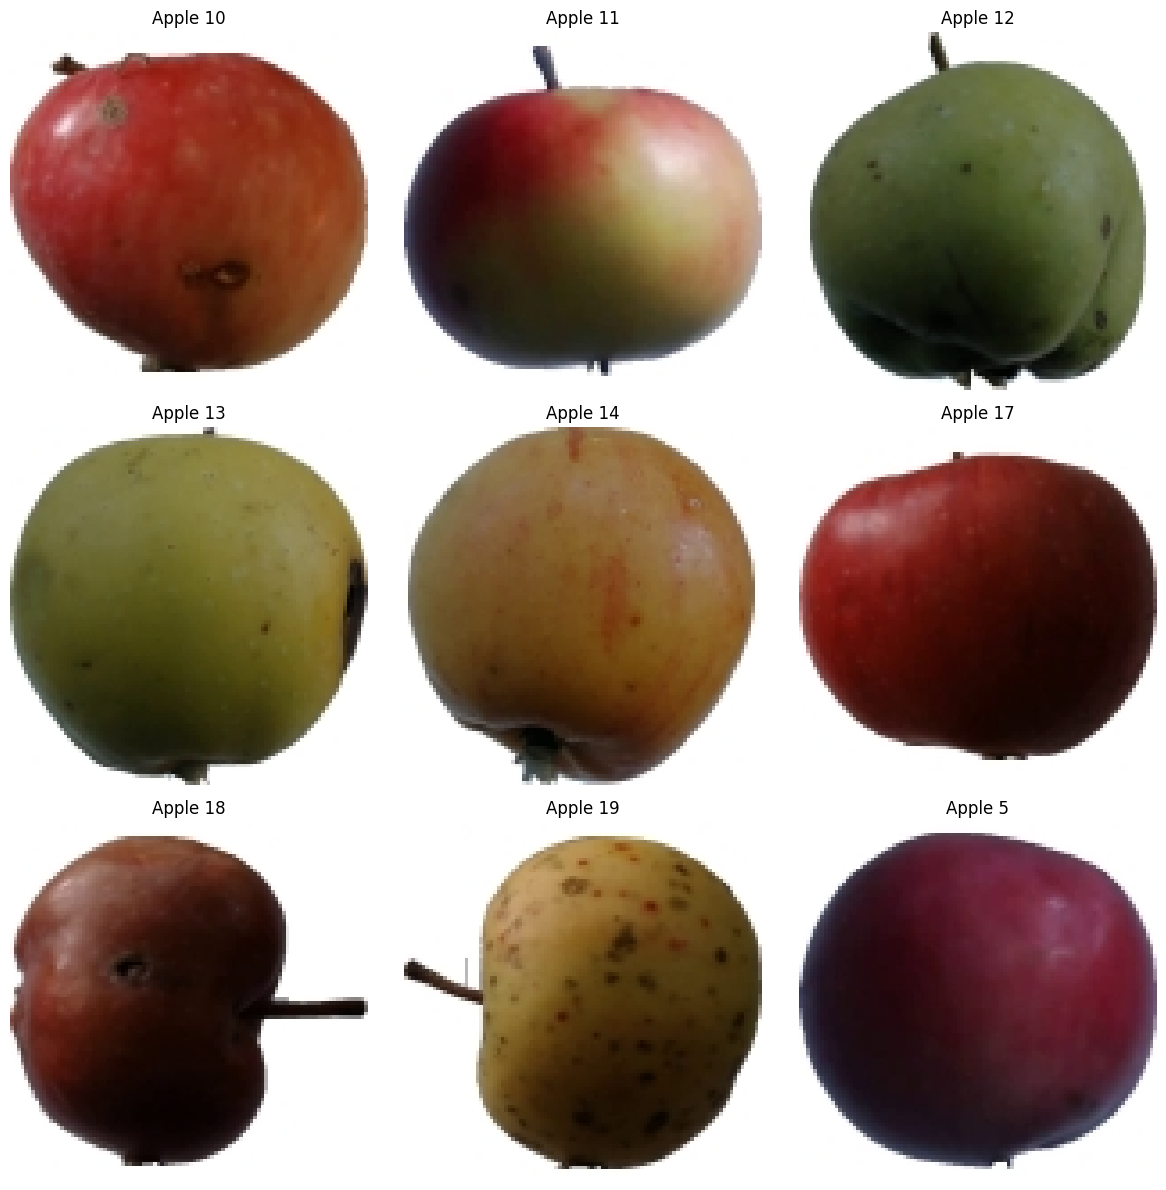

In [3]:
# Display some sample images
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.ravel()

for i, cls in enumerate(classes[:9]):
    img_path = os.path.join(training_path, cls, os.listdir(os.path.join(training_path, cls))[0])
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].set_title(cls)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## 4. Prepare Data for YOLO Classification
For YOLO classification tasks, we need to organize our data according to the Ultralytics documentation.

In [4]:
# Create a YOLO-compatible dataset structure for classification
yolo_dataset_path = 'datasets/fruits_yolo'

# Main directories
os.makedirs(yolo_dataset_path, exist_ok=True)

# For classification, we use a structure with class subfolders
train_path = os.path.join(yolo_dataset_path, 'train')
val_path = os.path.join(yolo_dataset_path, 'val')

# Create directories
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)

# Copy training data with class subdirectories
for cls in tqdm(classes, desc="Processing training set"):
    src_path = os.path.join(training_path, cls)
    dst_path = os.path.join(train_path, cls)
    os.makedirs(dst_path, exist_ok=True)
    
    for img_name in os.listdir(src_path):
        src_img = os.path.join(src_path, img_name)
        dst_img = os.path.join(dst_path, img_name)
        shutil.copy(src_img, dst_img)

# Copy validation data with class subdirectories
for cls in tqdm(classes, desc="Processing validation set"):
    src_path = os.path.join(test_path, cls)
    dst_path = os.path.join(val_path, cls)
    os.makedirs(dst_path, exist_ok=True)
    
    for img_name in os.listdir(src_path):
        src_img = os.path.join(src_path, img_name)
        dst_img = os.path.join(dst_path, img_name)
        shutil.copy(src_img, dst_img)

Processing validation set: 100%|██████████| 206/206 [00:10<00:00, 19.10it/s]


In [5]:
# Create YAML configuration file for YOLO Classification
yaml_path = os.path.join(yolo_dataset_path, 'data.yaml')

# For classification, we need to list classes in a dict with indices
yaml_content = {
    'path': os.path.abspath(yolo_dataset_path),
    'train': 'train',  # Path to train directory with class subfolders
    'val': 'val',      # Path to validation directory with class subfolders
    'names': {i: cls for i, cls in enumerate(classes)},  # Class index to name mapping
    'nc': len(classes)  # Number of classes
}

with open(yaml_path, 'w') as f:
    yaml.dump(yaml_content, f, default_flow_style=False)

print(f"YAML file created at: {yaml_path}")
print(f"Dataset prepared with {len(classes)} classes")
print(f"Structure is suitable for YOLO classification")

YAML file created at: datasets/fruits_yolo/data.yaml
Dataset prepared with 206 classes
Structure is suitable for YOLO classification


In [13]:
os.path.abspath(yaml_path)

'/home/kuba/Coding/Uczelnia/fridge_project/datasets/fruits_yolo/data.yaml'

## 5. Verify Dataset Structure

Let's verify that our dataset is correctly structured for YOLO classification by checking:
1. The YAML file content
2. The directory structure
3. Sample images in class folders

YAML file contains:
- Path: /home/kuba/Coding/Uczelnia/fridge_project/datasets/fruits_yolo
- Train: train
- Validation: val
- Number of classes: 206
- First 5 classes: ['Apple 10', 'Apple 11', 'Apple 12', 'Apple 13', 'Apple 14']

Training directory contains 207 class folders
Validation directory contains 207 class folders

Sample class 'Apple 10' contains 699 images


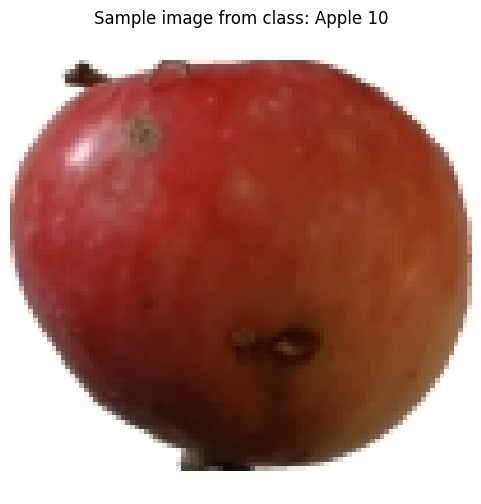

In [6]:
# 1. Check YAML file content
with open(yaml_path, 'r') as f:
    yaml_content = yaml.safe_load(f)
    
print("YAML file contains:")
print(f"- Path: {yaml_content['path']}")
print(f"- Train: {yaml_content['train']}")
print(f"- Validation: {yaml_content['val']}")
print(f"- Number of classes: {len(yaml_content['names'])}")
print(f"- First 5 classes: {[yaml_content['names'][i] for i in range(5)]}")

# 2. Check directory structure
train_classes = os.listdir(train_path)
val_classes = os.listdir(val_path)

print(f"\nTraining directory contains {len(train_classes)} class folders")
print(f"Validation directory contains {len(val_classes)} class folders")

# 3. Check sample images
sample_class = train_classes[0]
sample_images = os.listdir(os.path.join(train_path, sample_class))
print(f"\nSample class '{sample_class}' contains {len(sample_images)} images")

# Display a sample image
sample_img_path = os.path.join(train_path, sample_class, sample_images[0])
plt.figure(figsize=(6, 6))
img = Image.open(sample_img_path)
plt.imshow(img)
plt.title(f"Sample image from class: {sample_class}")
plt.axis('off')
plt.show()

## 6. Train YOLOv8 Classification Model with Memory Optimization
Now we'll train a YOLOv8 classification model on our prepared dataset using memory-efficient settings.

In [7]:
# Check available YOLO models
import pkg_resources
ultralytics_version = pkg_resources.get_distribution("ultralytics").version
print(f"Ultralytics version: {ultralytics_version}")

Ultralytics version: 8.3.158


/tmp/ipykernel_11751/883147239.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [8]:
# Memory-efficient training configuration
# 1. Significantly reduce batch size (most effective way to reduce memory usage)
batch_size = 64  # Adjust based on your GPU memory

# 2. Enable mixed precision training (uses less memory with minimal accuracy impact)
mixed_precision = True

# 3. Image size
img_size = 100  # Match the original image size of Fruits-360

# 4. Use CPU if GPU memory is extremely limited (much slower but no memory limits)
use_cpu = False  # Set to True to force CPU training

# Select device based on availability and configuration
if use_cpu:
    device = 'cpu'
    print("Using CPU for training (slower but no memory limits)")
else:
    device = 0 if torch.cuda.is_available() else 'cpu'
    if device != 'cpu':
        # Print GPU memory info
        gpu_name = torch.cuda.get_device_name(0)
        total_memory = torch.cuda.get_device_properties(0).total_memory / (1024**3)
        print(f"Using GPU: {gpu_name} with {total_memory:.2f} GB total memory")
    else:
        print("No GPU available, using CPU instead")

Using GPU: NVIDIA GeForce RTX 4050 Laptop GPU with 5.64 GB total memory


In [9]:
# IMPORTANT: For classification tasks, we must use the -cls model variant
try:
    # Make sure to use the classification model variant (note the "-cls" suffix)
    model = YOLO('yolov8n-cls.pt')  # Classification variant of YOLOv8n
    model_name = 'yolov8n-cls'
    print(f"Using {model_name} model (classification variant)")
except Exception as e:
    print(f"Model loading error: {e}")
    print("Make sure you have the latest ultralytics package installed")
    print("You can update with: pip install -U ultralytics")

Using yolov8n-cls model (classification variant)


In [15]:
# Modified training command with memory optimizations
# IMPORTANT: For classification tasks, ensure task='classify' is set or use a -cls model
results = model.train(
    # data=yaml_path,              # Use absolute path to avoid path resolution issues
    data=os.path.join("fruits_yolo", "data.yaml"),
    epochs=30,                   # Reduced number of epochs to start
    imgsz=img_size,
    batch=batch_size,            # Adjusted batch size for your GPU
    device=device,               # CPU or GPU based on earlier config
    name='fruits_model',
    verbose=True,
    amp=mixed_precision,         # Enable mixed precision training
    patience=10,                 # Early stopping if no improvement
    optimizer='AdamW',           # Memory-efficient optimizer
    cache=False,                 # Disable caching to use less memory
    val=True,                    # Validate after each epoch
    save=True,                   # Save model
    save_period=1,               # Save checkpoint after each epoch (important for resuming)
    exist_ok=True,               # Overwrite existing experiment
    workers=2,                   # Reduce worker threads if memory is limited
    task='classify'              # Explicitly set task to classification
)

New https://pypi.org/project/ultralytics/8.3.159 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.158 🚀 Python-3.13.3 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 5771MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=fruits_yolo/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=100, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=fruits_model, nbs=64, nms=False, o

######################################################################### 100.0%


RuntimeError: Dataset 'fruits_yolo/data.yaml' error ❌ [Errno 2] No such file or directory: '/home/kuba/Coding/Uczelnia/datasets/fruits_yolo/data.yaml/train'

## 7. Resuming Training After Shutdown

If you need to shut down your computer during training, you can safely do so after an epoch completes. When you come back, you can resume training from the last saved checkpoint with fewer epochs.

In [ ]:
# Run this cell when you want to resume training with fewer remaining epochs

# Path to the last checkpoint (will be in the 'runs/classify/fruits_model/' directory)
def resume_training_from_checkpoint(remaining_epochs=10):
    # Find the latest checkpoint
    checkpoint_dir = os.path.join('runs', 'classify', 'fruits_model')
    
    if not os.path.exists(checkpoint_dir):
        print(f"Checkpoint directory {checkpoint_dir} not found. Make sure you've run training first.")
        return
    
    # Find the weights directory
    weights_dir = os.path.join(checkpoint_dir, 'weights')
    if not os.path.exists(weights_dir):
        print(f"Weights directory {weights_dir} not found.")
        return
    
    # Look for the last checkpoint
    checkpoints = [f for f in os.listdir(weights_dir) if f.endswith('.pt') and 'last' in f]
    
    if not checkpoints:
        print("No checkpoint found to resume from.")
        return
    
    # Get the latest checkpoint
    last_checkpoint = os.path.join(weights_dir, 'last.pt')
    
    if os.path.exists(last_checkpoint):
        print(f"Resuming from checkpoint: {last_checkpoint}")
        # Load the model from checkpoint
        resumed_model = YOLO(last_checkpoint)
        
        # Resume training with fewer epochs
        results = resumed_model.train(
            data=yaml_path,
            epochs=remaining_epochs,  # Set the remaining number of epochs
            imgsz=img_size,
            batch=batch_size,
            device=device,
            name='fruits_model',  # Use the same project name to continue in the same directory
            exist_ok=True,        # Important - allows continuing in the same output directory
            resume=True,          # Resume from the last checkpoint
            amp=mixed_precision,
            patience=10,
            optimizer='AdamW',
            cache=False,
            val=True,
            save=True,
            save_period=1,
            workers=2,
            task='classify'
        )
        return results
    else:
        print(f"Last checkpoint file not found at {last_checkpoint}")

# Example usage:
# When you come back, set the number of remaining epochs you want to train for
# and execute this cell to resume training
# resume_training_from_checkpoint(remaining_epochs=20)

### How to Use the Resume Feature

1. Start your initial training with the cell above.
2. When you need to shut down, wait for the current epoch to complete (you'll see progress in the output).
3. After restarting your computer later, run the resume cell with your desired number of remaining epochs.
4. You can run this resume process multiple times as needed.

This approach allows you to:
- Safely interrupt long training sessions
- Adjust the total number of epochs based on model performance
- Continue training from exactly where you left off
- Preserve all the training history and metrics

### Additional Memory-Saving Tips

If you're still facing memory issues:

1. Try reducing batch size further (to 32, 16, or even 8)
2. Reduce the number of worker threads to 0
3. Use model pruning techniques after initial training
4. Consider training on a cloud service with more GPU memory

## 8. Evaluate the Model
After training, let's evaluate the model on the validation set.

In [ ]:
# Get the best model from the training results
best_model_path = os.path.join('runs', 'classify', 'fruits_model', 'weights', 'best.pt')

# Check if the best model exists
if os.path.exists(best_model_path):
    # Load the best model for evaluation
    best_model = YOLO(best_model_path)
    print(f"Loaded best model from: {best_model_path}")
    
    # Display model architecture information
    print(best_model.info())
else:
    print("Best model not found. Make sure training has completed successfully.")
    print("Using the last trained model instead.")
    best_model = model

Loaded best model from: runs/detect/fruits_model/weights/best.pt
YOLOv12n summary: 272 layers, 2,635,974 parameters, 0 gradients, 6.5 GFLOPs
(272, 2635974, 0, 6.516463999999999)


In [ ]:
# Evaluate the model on the validation set
val_results = best_model.val(data=yaml_path)
print(f"Validation results: {val_results}")

Ultralytics 8.3.158 🚀 Python-3.13.3 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 5771MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 381.7±223.7 MB/s, size: 5.5 KB)


val: Scanning /home/kuba/Coding/Uczelnia/fridge_project/datasets/fruits_yolo/val/Apple 10.cache... 0 images, 34711 backgrounds, 0 corrupt: 100%|██████████| 34711/34711 [00:00<?, ?it/s]

WARNING ⚠️ Labels are missing or empty in /home/kuba/Coding/Uczelnia/fridge_project/datasets/fruits_yolo/val/Apple 10.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2170/2170 [00:26<00:00, 81.51it/s]
/home/kuba/Coding/Uczelnia/fridge_project/.venv/lib64/python3.13/site-packages/ultralytics/utils/metrics.py:583: RuntimeWarning: Mean of empty slice.
  ax.plot(px, py.mean(1), linewidth=3, color="blue", label=f"all classes {ap[:, 0].mean():.3f} mAP@0.5")
/home/kuba/Coding/Uczelnia/fridge_project/.venv/lib64/python3.13/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/kuba/Coding/Uczelnia/fridge_project/.venv/lib64/python3.13/site-packages/ultralytics/utils/metrics.py:628: RuntimeWarning: Mean of empty slice.
  y = smooth(py.mean(0), 0.1)
/home/kuba/Coding/Uczelnia/fridge_project/.venv/lib64/python3.13/site-packages/numpy/_core/_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/kuba/Coding/Uczelnia/fridge_

                   all      34711          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels
Speed: 0.0ms preprocess, 0.5ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to /home/kuba/Coding/Uczelnia/fridge_project/runs/detect/val2
Validation results: ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([], dtype=int64)
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fd16a5e9bd0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.

## 9. Test on Sample Images
Let's test our trained model on some sample images from the test set.

In [ ]:
# Test the model on sample images
test_img_paths = []
for cls in classes[:5]:  # Test on 5 different fruit classes
    img_path = os.path.join(test_path, cls, os.listdir(os.path.join(test_path, cls))[0])
    test_img_paths.append((img_path, cls))

# Perform inference and display results
plt.figure(figsize=(15, 12))
for i, (img_path, true_class) in enumerate(test_img_paths):
    # Run inference
    results = best_model.predict(img_path)
    
    # Get prediction details (make sure we're accessing classification results)
    probs = results[0].probs  # Classification probability distribution
    pred_class = results[0].names[probs.top1]  # Predicted class
    confidence = probs.top1conf.item()  # Confidence score
    
    # Display image with predictions
    plt.subplot(2, 3, i+1)
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title(f"True: {true_class}\nPred: {pred_class}\nConf: {confidence:.2f}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## 10. Save the Model
Finally, let's save our trained model in different formats for future use.

In [ ]:
# Save the model in different formats
best_model.export(format='onnx')  # ONNX format for broader compatibility
print(f"Model exported to: runs/classify/fruits_model/weights/")

# You can also save in other formats
# best_model.export(format='torchscript')  # TorchScript format
# best_model.export(format='tflite')       # TensorFlow Lite format

## 11. Conclusion
We've successfully trained a YOLOv8 classification model on the Fruits-360 dataset following the official Ultralytics documentation. The model can now be used for fruit classification in various applications, including smart refrigerator systems that can identify fruits.

### Verify Class Name Mapping

Let's verify that our model correctly maps prediction indices to class names rather than showing numbers:

In [ ]:
# Pick a sample image
sample_cls = classes[0]  # First class
sample_img_path = os.path.join(test_path, sample_cls, os.listdir(os.path.join(test_path, sample_cls))[0])

# Run inference
results = best_model.predict(sample_img_path)

# Display the mapping details
print(f"Sample image from class: {sample_cls}")
print("\nPrediction details:")
print(f"Top prediction index (probs.top1): {results[0].probs.top1}")
print(f"Class name from mapping: {results[0].names[results[0].probs.top1]}")
print(f"Confidence: {results[0].probs.top1conf.item():.4f}")

# Show all top 5 predictions with class names
top5i = results[0].probs.top5
top5p = results[0].probs.top5conf
print("\nTop 5 predictions:")
for i, (idx, prob) in enumerate(zip(top5i, top5p)):
    print(f"{i+1}. {results[0].names[idx]} ({prob:.4f})")

# Display the image with its prediction
plt.figure(figsize=(6, 6))
img = plt.imread(sample_img_path)
plt.imshow(img)
plt.title(f"True: {sample_cls}\nPred: {results[0].names[results[0].probs.top1]}\nConf: {results[0].probs.top1conf.item():.4f}")
plt.axis('off')
plt.show()